# Introduction
This is a dataset of the elo of every NBA game from the 2022-2023 season. Elo is used to measure the relative strength of every game. Raptor is is a plus-minus statistic that measures the number of points a player contributes to his team’s offense and defense per 100 possessions, relative to a league-average player. A team's raptor score is essentially an aggregate of the raptor ratings of all of the players on the team. The dataset came from https://data.fivethirtyeight.com/ and they compiled it using information from Basketball-Reference.com

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
#code to import the data from a local file
elo = pd.read_csv("nba_elo_latest.csv")
#Selecting feature columns that are meaningful for clustering.
elo_features = elo[['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post', 'raptor1_pre', 'raptor2_pre', 'raptor_prob1', 'raptor_prob2', 'score1', 'score2', 'quality', 'importance', 'total_rating']]
#Checking for and removing any outliers in the data
def is_outlier(x):
    Q25, Q75 = x.quantile([.25,.75])
    I = Q75 - Q25
    return (x < Q25 - 1.5*I) |  (x > Q75 + 1.5*I)

outliers = elo_features.apply(is_outlier)
elo_features = elo_features[~outliers.any(axis=1)]
elo_features.head()

,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,score1,score2,quality,importance,total_rating
0,1657.639749,1582.247327,0.732950,0.267050,1662.198884,1577.688193,1693.243079,1641.876729,0.670612,0.329388,126,117,96,13,55
1,1660.620307,1442.352444,0.862011,0.137989,1663.449489,1439.523261,1615.718147,1472.173711,0.776502,0.223498,123,109,67,20,44
2,1399.201934,1440.077372,0.584275,0.415725,1388.883119,1450.396186,1462.352663,1472.018225,0.599510,0.400490,107,114,37,28,33
3,1393.525172,1366.089249,0.675590,0.324410,1397.248913,1362.365508,1308.969909,1349.865183,0.563270,0.436730,113,109,3,1,2
4,1535.408152,1351.164973,0.837022,0.162978,1538.164082,1348.409043,1618.256817,1283.328356,0.917651,0.082349,117,107,24,1,13


# Results
 

KMeans: 0.2815783115516038
Agglomerative Ward: 0.27216800007850445
Agglomerative Complete: 0.2205110927210033
Agglomerative Average: 0.2720663677228383
   kmeans_n_clusters  silhouette
0                  2    0.251589
1                  3    0.281578
2                  4    0.219495
3                  5    0.209943
4                  6    0.223884
5                  7    0.223570
6                  8    0.208369
7                  9    0.202292
8                 10    0.191374
   ward_n_clusters  silhouette
0                2    0.272168
1                3    0.212739
2                4    0.184214
3                5    0.173350
4                6    0.172884
5                7    0.172394
6                8    0.176647
7                9    0.160766
8               10    0.149098
   complete_n_clusters  silhouette
0                    2    0.220511
1                    3    0.217720
2                    4    0.164933
3                    5    0.142659
4                    6    0.09836

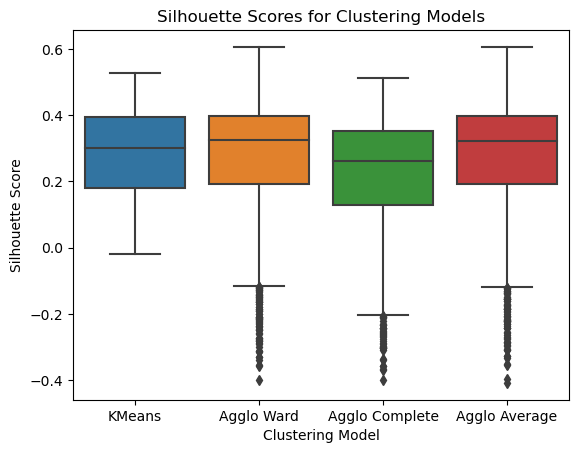

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
#Standardizing the data
scaler = StandardScaler()
elo_features_scaled = scaler.fit_transform(elo_features)
#Creating a KMeans model 
kmeans = KMeans(n_clusters=3, random_state=302, n_init=10)
kmeans.fit(elo_features_scaled)
#Creating Agglomerative Clustering models with 5 clusters using three different linkage types
agg1 = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg1.fit(elo_features_scaled)
agg2 = AgglomerativeClustering(n_clusters=2, linkage='complete')
agg2.fit(elo_features_scaled)
agg3 = AgglomerativeClustering(n_clusters=2, linkage='average')
agg3.fit(elo_features_scaled)
#Making a box plot showing the silhouette scores for each clustering model
kmeans_silhouette = silhouette_samples(elo_features_scaled, kmeans.labels_)
agg1_silhouette = silhouette_samples(elo_features_scaled, agg1.labels_)
agg2_silhouette = silhouette_samples(elo_features_scaled, agg2.labels_)
agg3_silhouette = silhouette_samples(elo_features_scaled, agg3.labels_)
silhouette_scores = pd.DataFrame({
    'KMeans': kmeans_silhouette,
    'Agglo Ward': agg1_silhouette,
    'Agglo Complete': agg2_silhouette,
    'Agglo Average': agg3_silhouette
})
ax = sns.boxplot(data=silhouette_scores)
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for Clustering Models')
ax.set_xlabel('Clustering Model')
#Printing the silhouette scores for each model
print('KMeans:', silhouette_score(elo_features_scaled, kmeans.labels_))
print('Agglomerative Ward:', silhouette_score(elo_features_scaled, agg1.labels_))
print('Agglomerative Complete:', silhouette_score(elo_features_scaled, agg2.labels_))
print('Agglomerative Average:', silhouette_score(elo_features_scaled, agg3.labels_))

#Finding the best number of clusters for each clustering method
k_results = []
w_results = []
c_results = []
a_results = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=302, n_init=10)
    kmeans.fit(elo_features_scaled)
    k_results.append({
        'kmeans_n_clusters': n,
        'silhouette': silhouette_score(elo_features_scaled, kmeans.labels_)
    })
    agg = AgglomerativeClustering(n_clusters=n, linkage='ward')
    agg.fit(elo_features_scaled)
    w_results.append({
        'ward_n_clusters': n,
        'silhouette': silhouette_score(elo_features_scaled, agg.labels_)
    })
    agg = AgglomerativeClustering(n_clusters=n, linkage='complete')
    agg.fit(elo_features_scaled)
    c_results.append({
        'complete_n_clusters': n,
        'silhouette': silhouette_score(elo_features_scaled, agg.labels_)
    })
    agg = AgglomerativeClustering(n_clusters=n, linkage='average')
    agg.fit(elo_features_scaled)
    a_results.append({
        'average_n_clusters': n,
        'silhouette': silhouette_score(elo_features_scaled, agg.labels_)
    })
k_results = pd.DataFrame(k_results)
w_results = pd.DataFrame(w_results)
c_results = pd.DataFrame(c_results)
a_results = pd.DataFrame(a_results)

print(k_results)
print(w_results)
print(c_results)
print(a_results)

#Finding the best clustering method
results = pd.concat([k_results, w_results, c_results, a_results], axis=1)
max_silhouette_per_cluster = results.max()
best_method = max_silhouette_per_cluster.idxmax()

print("Best Clustering Method:", best_method)


<Axes: xlabel='Clustering Method', ylabel='Silhouette Score'>

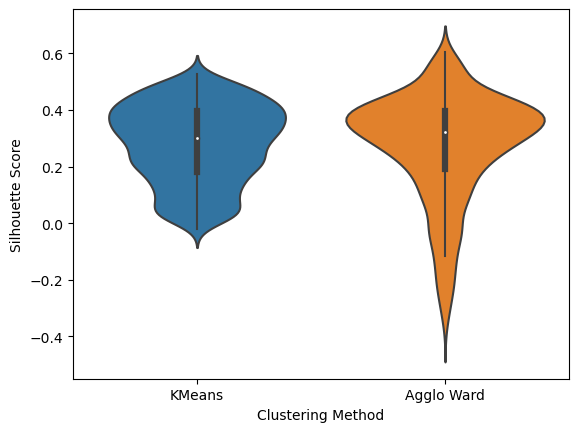

In [3]:
#Violin plot of silhouette scores for the best clustering(kmeans where n_clusters=3) and the second best clustering(agglomerative clustering with ward linkage where n_clusters=2)
vp_data = silhouette_scores[['KMeans', 'Agglo Ward']]
vp_data = vp_data.melt(var_name='Clustering Method', value_name='Silhouette Score')
sns.violinplot(x='Clustering Method', y='Silhouette Score', data=vp_data)


# Discussion
After comparing the results from multiple numbers of clusters I can say that 3 clusters is the best number for k-means as it yielded the greatest silhouette score. This shows that the data on NBA games I used fits into three different groups. Each cluster represents some pattern of scenarios that happen in NBA games. 

For all three agglomerative clustering methods I chose, 2 clusters was the best number because it yielded the greatest silhouette score. This implies that all 3 linkage methods found that the data on NBA games I used fits into 2 different groups. Suggesting that the pattern of scenarios that happen in NBA games best fit into binary categories.

K-means was the best overall clustering algorithm, having the best max silhouette score. This means that the k-means is better at finding similarities in the data than all of the agglomerative clustering methods I chose. This also means that NBA game data best fits into three distinct categories.

